In [1]:
! ls

Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
beta_glu_DMS_log2enrichment_melted.csv
bglb__elastic_net__enzyme_design-Copy1.ipynb
bglb__elastic_net__enzyme_design.ipynb
create_ML_targets.ipynb
custom_feature_set.ipynb
data.h5
data2.h5
data_set_protein_sequence.fa
diabetes_practice
diabetes_practice.ipynb
en__big_feat_set__modern.ipynb
en__big_feat_set__stock_enzyme_design.ipynb
expression__bglb_feature_selection.ipynb
expression__freezer.ipynb
expression_bglb
expression_bglb__mutate_only.ipynb
expression_bglb__repack_only.ipynb
expression_freezer
features.csv
features.h5
full_family_feature_set.ipynb
gp_bglb_kinetic.ipynb
neighborhood_test.ipynb
pacbio_run_analysis.ipynb
results.h5
sequence-based
train_elastic_net_models-Copy1.ipynb
train_elastic_net_models.ipynb


In [1]:
import pandas 
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import feature_selection, preprocessing, pipeline, linear_model, neural_network, model_selection

In [2]:
# begin with the targets 

t = pandas.read_csv('../data_sets/bglb_ML_targets.csv', index_col=0)

# I found that E164D was seriously outlier in
# some of the most-correlated features 
# so removing it 

t = t.drop(['E164D'], axis=0)

t.head()

,kcat,km,kcatkm
mutant_name,,,
S14A,-0.439333,0.217484,-0.651460
T15A,-0.156314,0.025306,-0.176657
S16A,-0.756962,0.447468,-1.199275
S17A,-0.016087,0.567026,-0.577999
S17E,-0.137625,0.165541,-0.298065


In [3]:
t.shape

(110, 3)

In [4]:
# experiemntal highly! # 

# add some nonfunctionals with kcatkms of -5 

In [5]:
! rsync -avz ca:/share/work/alex/bglb_family/rosetta_runs/bglb/enzyme_design/features.h5 .  

/home/carlin/.bashrc: line 3: bind: warning: line editing not enabled
receiving file list ... done

sent 16 bytes  received 92 bytes  72.00 bytes/sec
total size is 3808690  speedup is 35265.65


In [6]:
f = pandas.read_hdf('features.h5')
f.shape

(7967, 59)

In [7]:
f.head()

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
N1A,-2767.265,434.821,-82.008,0.0,0.659,0.651,164.3,417.5,264.6,4.200,...,0.851,446.0,-7.746,1.909,-2.561,1.353,-11.497,0.890,6.7,0.0
N1C,-2762.902,433.981,-81.513,0.0,0.658,0.651,164.3,417.1,265.0,3.667,...,0.771,446.0,-8.092,1.927,-2.517,1.210,-12.187,0.885,6.4,0.0
N1D,-2765.736,434.348,-81.843,0.0,0.652,0.646,165.5,416.7,265.4,3.605,...,0.830,446.0,-7.659,1.942,-2.574,1.337,-11.321,0.889,5.9,0.0
N1E,-2730.843,434.063,-82.278,0.0,0.646,0.643,164.2,417.9,264.7,3.843,...,0.860,446.0,-8.074,1.935,-2.759,1.113,-12.146,0.890,6.5,0.0
N1F,-2761.816,433.389,-82.594,0.0,0.651,0.645,164.9,417.4,265.2,4.237,...,0.877,446.0,-8.071,1.827,-2.625,0.964,-12.140,0.893,6.5,0.0


In [8]:
df = f.join(t).dropna()
df.shape

(105, 62)

In [9]:
# which mutants are not represented in our feature space then? 
[n for n in t.index if n not in df.index]

['BglB', 'A227W', 'X123Y', 'E353E', 'E353E']

In [10]:
# well, good, because those are bullshit 

In [11]:
# lets do the regular descriptive statistics here 

df.describe()

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,kcat,km,kcatkm
count,105.000000,105.000000,105.000000,105.0,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,-2729.695057,443.904091,-81.314395,0.0,0.648085,0.643101,165.045212,416.564471,264.219974,3.694440,...,1.995977,-2.539841,1.782089,-11.120839,0.893501,6.124180,0.058413,-0.757903,0.172661,-0.941951
std,154.602632,43.005378,1.226595,0.0,0.004790,0.004114,1.904045,1.204933,1.359742,0.271939,...,0.114431,0.264081,0.565048,1.079387,0.016227,0.629991,0.236632,0.847189,0.431185,1.068431
min,-2769.558750,428.516000,-83.341000,0.0,0.633000,0.631000,162.100000,412.700000,259.400000,2.507778,...,1.686000,-3.049000,0.557000,-14.405000,0.845556,1.000000,0.000000,-3.643453,-1.096910,-4.044650
25%,-2765.546000,433.287000,-82.088889,0.0,0.645000,0.641000,163.800000,415.900000,263.500000,3.543000,...,1.920000,-2.649000,1.342000,-11.601111,0.888000,6.000000,0.000000,-1.344600,-0.055517,-1.468448
50%,-2763.093333,434.225000,-81.604444,0.0,0.648000,0.644000,164.700000,416.800000,264.500000,3.678000,...,1.998000,-2.555000,1.818000,-11.095000,0.893000,6.200000,0.000000,-0.439333,0.101059,-0.592414
75%,-2759.290000,434.933000,-80.903000,0.0,0.651000,0.646000,166.100000,417.400000,265.125000,3.813000,...,2.052000,-2.500000,2.148000,-10.662222,0.900000,6.400000,0.000000,-0.118408,0.385964,-0.160840
max,-1677.197000,758.247000,-76.900000,0.0,0.663000,0.654000,172.000000,418.625000,266.600000,4.754000,...,2.557000,-0.375000,3.042000,-4.639000,0.947500,7.500000,2.000000,1.097344,1.814514,0.955350


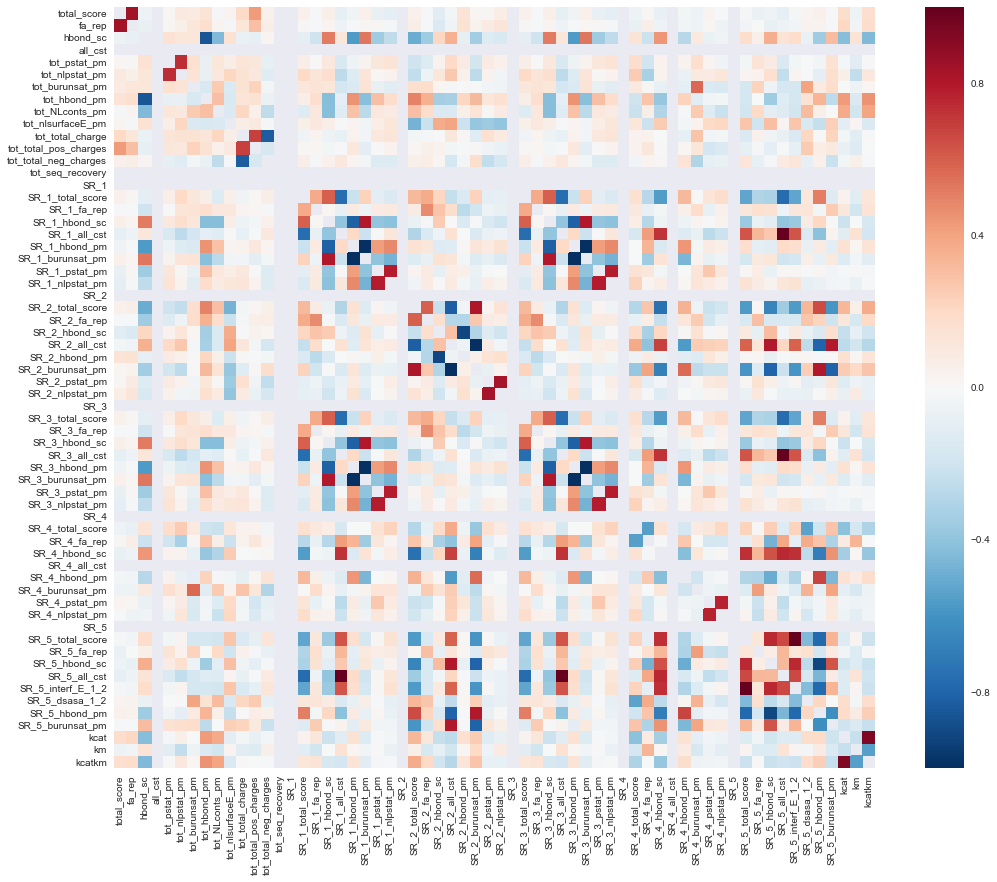

In [12]:
corr = df.corr()
mask = corr < 1

plt.figure(figsize=(18,14))
sns.heatmap(corr.mask(~mask), square=1)

In [13]:
targets = 'kcat km kcatkm'.split()
features = [n for n in df.columns if n not in targets]

In [14]:
# calculate all the individual feature correlations for the Leekasso 
corr[targets].dropna().drop(targets, axis=0).sort_values(targets)

,kcat,km,kcatkm
hbond_sc,-0.422980,0.134982,-0.445124
SR_4_total_score,-0.407584,-0.172908,-0.308398
SR_4_hbond_sc,-0.340072,0.021108,-0.387414
SR_2_all_cst,-0.260258,-0.194039,-0.284483
SR_2_hbond_sc,-0.238990,-0.088559,-0.203106
SR_1_hbond_sc,-0.213441,-0.003501,-0.167313
SR_3_hbond_sc,-0.213441,-0.003501,-0.167313
SR_5_burunsat_pm,-0.206303,-0.152760,-0.228628
SR_5_hbond_sc,-0.189200,-0.136323,-0.220909
SR_5_total_score,-0.139648,0.028271,-0.215093


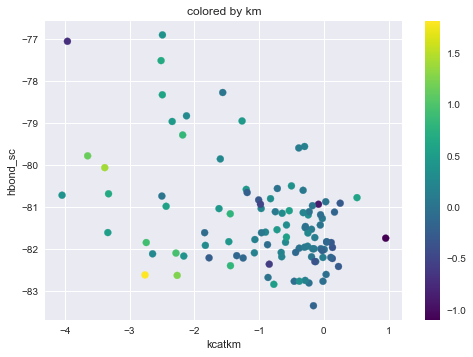

In [15]:
feature = 'hbond_sc'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

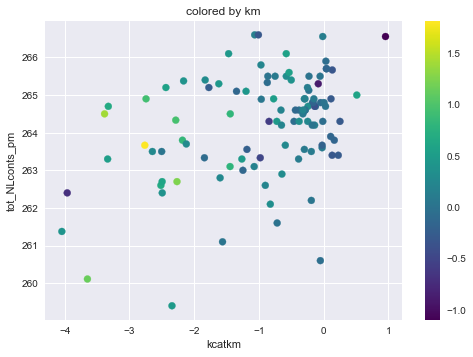

In [16]:
feature = 'tot_NLconts_pm'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

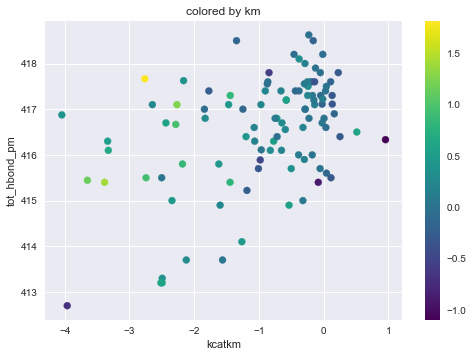

In [17]:
feature = 'tot_hbond_pm'
plt.scatter(df.kcatkm, df[feature], c=df.km, cmap='viridis')
plt.colorbar()
plt.title('colored by km')
plt.xlabel('kcatkm')
plt.ylabel(feature)

In [18]:
#df.query('tot_hbond_pm<408')
# used this to find that E164D was the outlier 

In [19]:
# first, let's clean the data 

def deadbeats():
    for column in df:
        if df[column].std() == 0.0:
            yield column 
            
list(deadbeats())

def list_features():
    for column in df:
        if column not in targets:
            yield column  
            
list(list_features())

df = df.drop(['SR_1', 'SR_2', 'SR_3', 'SR_4', 'SR_5', 'all_cst'], axis=1)
df.shape

(105, 56)

Cool, we are down to 56 features and 105 samples 

In [20]:
df.head()

,total_score,fa_rep,hbond_sc,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,tot_total_charge,...,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,kcat,km,kcatkm
A192S,-2726.385000,437.294000,-80.868000,0.650000,0.646000,167.400000,417.400000,264.700000,3.549000,-27.0,...,2.000000,-2.421000,2.170000,-10.684000,0.902000,5.700000,0.0,0.031408,0.007748,0.028609
C167A,-2765.653000,433.420000,-81.533000,0.648000,0.642000,163.400000,416.800000,264.300000,3.857000,-27.0,...,1.974000,-2.573000,2.087000,-10.485000,0.891000,6.000000,0.0,-0.264147,0.464191,-0.723565
C167Q,-2758.906250,436.748750,-82.800000,0.652500,0.646250,165.375000,418.625000,265.125000,3.480000,-27.0,...,2.240000,-2.690000,2.536250,-10.413750,0.898750,6.125000,0.0,-0.242052,-0.007005,-0.230186
C167S,-2764.227778,433.561111,-82.608889,0.651111,0.644444,164.222222,417.666667,263.666667,3.773333,-27.0,...,1.947778,-2.755556,2.694444,-9.887778,0.890000,6.333333,0.0,-0.953700,1.814514,-2.763251
D322A,-2767.297778,434.307778,-81.888889,0.655556,0.645556,163.444444,417.555556,265.333333,3.621111,-26.0,...,1.984444,-2.536667,1.942222,-11.022222,0.904444,6.222222,0.0,-0.941022,-0.065502,-0.870557


Let's have a look at the feature space 

In [21]:
from sklearn import preprocessing
import re 

/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


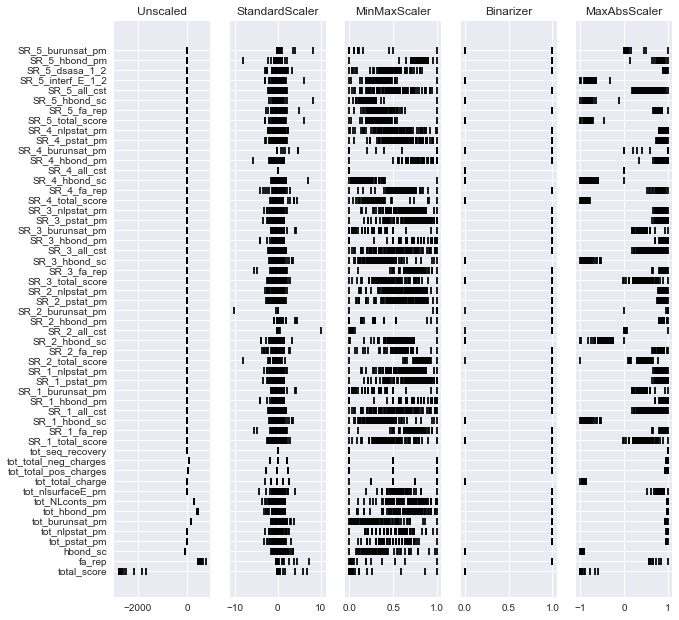

In [22]:
feats = list(list_features())
scalers = [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), preprocessing.Binarizer(), preprocessing.MaxAbsScaler() ]

fig, ax = plt.subplots(1, len(scalers)+1, figsize=(10, 0.2*len(feats)), sharey='all' )
f = df[feats]
for n, column in enumerate(f):
    x = f[column] 
    y = [n] * len(x) 
    ax[0].scatter(x, y, marker='|', color='black')
    ax[0].set_yticks(range(len(feats)))
    ax[0].set_title('Unscaled')
    for m, scaler in enumerate(scalers): 
        d = pandas.DataFrame(scaler.fit_transform(f), columns=f.columns, index=f.index)
        if column not in targets: 
            x = d[column] 
            y = [n] * len(x) 
            ax[m+1].scatter(x, y, marker='|', color='black')
            ax[m+1].set_yticks(range(len(feats)))
            ax[m+1].set_title(re.sub(r'\(.*', '', str(scaler)))
            
ax[0].set_yticklabels(f.columns)
fig.show()

OK, it looks like we will certainly need to scale the features. Let's do that now. I think the `StandardScaler` is what I'm going to go with, at least for now. 

In [79]:
scaler = preprocessing.MinMaxScaler()
scaled_features = pandas.DataFrame(scaler.fit_transform(f), columns=f.columns, index=f.index)
df = df[targets].join(scaled_features).dropna()

print(df.shape)
df.head()

(175, 56)


,kcat,km,kcatkm,total_score,fa_rep,hbond_sc,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,...,SR_4_pstat_pm,SR_4_nlpstat_pm,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
A192S,0.031408,0.007748,0.028609,0.039523,0.026622,0.383947,0.566667,0.652174,0.535354,0.793249,...,0.352227,0.359375,0.380913,0.360505,0.234854,0.649095,0.381016,0.553678,0.723077,0.0
C167A,-0.264147,0.464191,-0.723565,0.003576,0.014873,0.280702,0.500000,0.478261,0.131313,0.691983,...,0.562753,0.541667,0.401802,0.330654,0.178010,0.615694,0.401393,0.445777,0.769231,0.0
C167Q,-0.242052,-0.007005,-0.230186,0.009752,0.024968,0.083993,0.650000,0.663043,0.330808,1.000000,...,0.677126,0.446615,0.408919,0.636051,0.134256,0.796479,0.408688,0.521798,0.788462,0.0
C167S,-0.953700,1.814514,-2.763251,0.004880,0.015301,0.113664,0.603704,0.584541,0.214366,0.838256,...,0.543860,0.542824,0.462762,0.300549,0.109740,0.860139,0.462546,0.435967,0.820513,0.0
D322A,-0.941022,-0.065502,-0.870557,0.002070,0.017565,0.225448,0.751852,0.632850,0.135802,0.819503,...,0.642825,0.508102,0.346486,0.342646,0.191598,0.557433,0.346383,0.577657,0.803419,0.0


In [80]:
df.corr()[targets].sort_values(targets)

,kcat,km,kcatkm
SR_4_total_score,-0.418352,-0.094719,-0.323103
hbond_sc,-0.412974,0.165018,-0.419889
km,-0.387230,1.000000,-0.667357
SR_4_hbond_sc,-0.302384,0.052040,-0.333401
SR_2_all_cst,-0.250424,-0.149694,-0.260119
SR_2_hbond_sc,-0.236895,-0.055113,-0.197854
SR_5_burunsat_pm,-0.210058,-0.108921,-0.220847
SR_1_hbond_sc,-0.209768,0.028945,-0.170244
SR_3_hbond_sc,-0.209768,0.028945,-0.170244
SR_5_hbond_sc,-0.206261,-0.089080,-0.223696


Enough mucking about! Let's do some machine _learning_ (as Andrew Ng would say) 

In [83]:
from sklearn import linear_model, feature_selection, model_selection



In [84]:

df.shape

(175, 56)

In [85]:
df.head()

,kcat,km,kcatkm,total_score,fa_rep,hbond_sc,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,...,SR_4_pstat_pm,SR_4_nlpstat_pm,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
A192S,0.031408,0.007748,0.028609,0.039523,0.026622,0.383947,0.566667,0.652174,0.535354,0.793249,...,0.352227,0.359375,0.380913,0.360505,0.234854,0.649095,0.381016,0.553678,0.723077,0.0
C167A,-0.264147,0.464191,-0.723565,0.003576,0.014873,0.280702,0.500000,0.478261,0.131313,0.691983,...,0.562753,0.541667,0.401802,0.330654,0.178010,0.615694,0.401393,0.445777,0.769231,0.0
C167Q,-0.242052,-0.007005,-0.230186,0.009752,0.024968,0.083993,0.650000,0.663043,0.330808,1.000000,...,0.677126,0.446615,0.408919,0.636051,0.134256,0.796479,0.408688,0.521798,0.788462,0.0
C167S,-0.953700,1.814514,-2.763251,0.004880,0.015301,0.113664,0.603704,0.584541,0.214366,0.838256,...,0.543860,0.542824,0.462762,0.300549,0.109740,0.860139,0.462546,0.435967,0.820513,0.0
D322A,-0.941022,-0.065502,-0.870557,0.002070,0.017565,0.225448,0.751852,0.632850,0.135802,0.819503,...,0.642825,0.508102,0.346486,0.342646,0.191598,0.557433,0.346383,0.577657,0.803419,0.0


In [86]:
import numpy as np 

TypeError: split() missing 1 required positional argument: 'y'

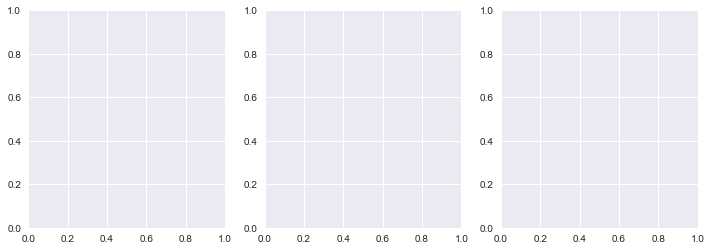

In [94]:

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4)) 

for n, target_name in enumerate(targets):
    
    my_ax = ax[n] 
    X = df[feats]
    y = df[target_name].ravel()
 
    for n in range(10):
    
        shuff = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
        clf = linear_model.ElasticNetCV(l1_ratio=[0.5, 0.9], cv=shuff, selection='random', max_iter=1e4)
        clf.fit(X, y)
        
        preds = clf.predict(X) 
        
            
        lr = linear_model.LinearRegression()
        lr.fit(y.reshape(-1, 1), preds)
        x_vals = np.linspace(y.min(), y.max(), 10)
        y_vals = lr.predict(x_vals.reshape(-1, 1)) 
            
        # plot 
        my_ax.plot(x_vals, y_vals) 
        my_ax.scatter(y, preds) 
        lim = my_ax.get_xlim()
        my_ax.set_ylim(lim)


            
            #clf = linear_model.ElasticNetCV(l1_ratio=[0.5, 0.9, 0.99], cv=10, max_iter=1e5)



In [25]:
from scipy.stats import pearsonr

In [46]:
# def leekasso(X, y):
#     if isinstance(X, pandas.DataFrame):
#         X = X.as_matrix()
#     scores = []
#     pvalues = []
#     n_samples, n_features = X.shape 
#     for n in range(n_features):
#         x = X[:, n]
#         r, p = pearsonr(x, y) 
#         scores.append(r)
#         pvalues.append(pvalues)
# #         yield r, p 
#     return scores, pvalues 
                
# X = df[feats]
# y = df.kcat
# results = leekasso(X, y)

In [47]:
# list(results)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(df.kcatkm, pred)
lim = ax.get_xlim() 
ax.set_ylim(lim)
ax.set(xlabel='Measured', ylabel='Predicted')

In [ ]:
# now, read in features from another protein 

In [ ]:
! rsync -avz ca:/share/work/alex/bglb_family/rosetta_runs/run_A/enzyme_design/features.h5 .  

In [ ]:
p = pandas.read_hdf('features.h5')

In [ ]:
names = pandas.read_csv('../data_sets/names.csv', index_col=0)
names

In [ ]:
mut_names = [n for n in list(names.T['Q7MG41_142']) if n != 'WT'] + ['Q27Q']
mut_names

In [ ]:
mut_feats = p.loc[mut_names].dropna()
mut_feats

In [ ]:
pred2 = grid.predict(mut_feats)
pred2

In [ ]:
pred_map = dict(zip(mut_feats.index, pred2))
pred_map

In [ ]:
my_series = names.T['Q7MG41_142']
my_series.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]

In [ ]:
# get the actual values 
data = pandas.read_csv('../data_sets/family_data_set.csv')
s = data[(data.scaffold == 'Q7MG41_142') & (data.kinetic_constant == 'kcatkm') & (data.rel_or_abs == 'rel')].copy()
s['mutant'] = s.mutant_name_index.map(my_series)
s['prediction'] = s.mutant.map(pred_map)
s

In [ ]:
plt.scatter(s.value, s.prediction)
plt.xlabel('Experimental kcat/km, log10(mutant/native)')
plt.ylabel('Blind prediction trained on BglB data set')

In [ ]:
p.head()

In [ ]:
all_p = grid.predict(p)

In [ ]:
plt.hist(all_p, bins=50)

In [ ]:
all_f = grid.predict(f)
plt.hist(all_f, bins=50)

In [ ]:
df.kcatkm.hist(bins=50)